In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

from tqdm import tqdm_notebook as tqdm
import random

c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\limxu\appd

## Set up

In [2]:
data_df = pd.read_csv("C:\\Users\\limxu\\Documents\\Intern\\data\\train_data.csv", index_col = 0)
print(data_df.head())

                                          image_path  frame      speed
0  C:\Users\limxu\Documents\Intern\data\ori_image...      0  28.105569
1  C:\Users\limxu\Documents\Intern\data\ori_image...      1  28.105569
2  C:\Users\limxu\Documents\Intern\data\ori_image...      2  28.106527
3  C:\Users\limxu\Documents\Intern\data\ori_image...      3  28.130404
4  C:\Users\limxu\Documents\Intern\data\ori_image...      4  28.109243


## Function

In [3]:
def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    randomized_list = np.arange(len(dframe)-1)
    np.random.shuffle(randomized_list)
    
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    
    for i in tqdm(randomized_list):
        idx1 = i
        idx2 = i + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(10)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt == 2:
            test_frames = [test_data, row1, row2]
            test_data = pd.concat(test_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt > 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
            
    return train_data, valid_data, test_data

In [4]:
# create training and validation set
train_data, valid_data, test_data = batch_shuffle(data_df)

# verify data size
print ('Training data size =', train_data.shape)
print ('Validation data size =', valid_data.shape)
print ('Test data size =', test_data.shape)


Training data size = (28722, 4)
Validation data size = (8052, 4)
Test data size = (4024, 4)


In [6]:
train_data.to_csv("C:\\Users\\limxu\\Documents\\Intern\\data\\train_set.csv")
valid_data.to_csv("C:\\Users\\limxu\\Documents\\Intern\\data\\valid_set.csv")
test_data.to_csv("C:\\Users\\limxu\\Documents\\Intern\\data\\test_set.csv")

## Preprocessing

### Change brightness

In [7]:
#if bright factor is 0.5, adding np.random.uniform() helps to give an 'equal' chance for images to be brightened or dimmed

def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    
    # perform brightness augmentation only on the second channel
    #value of 0.6 is used because i rather the brightness be lower
    hsv_image[:,:,2] = hsv_image[:,:,2] * (0.5 + bright_factor)
    
    hsv_image[:, :, 2][hsv_image[:, :, 2] > 255] = 255 #reset out of range values
    
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

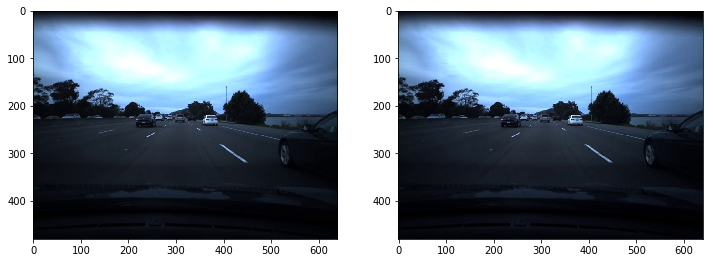

image path is C:\Users\limxu\Documents\Intern\data\ori_images\frame2234.jpg


In [16]:
#test brightness augmentation

dir_name = "C:\\Users\\limxu\\Documents\\Intern\\data\\ori_images\\" #directory of all original frame images
test_img_path = random.choice(os.listdir(dir_name))
test_img_path = dir_name + test_img_path
test_img = mpimg.imread(test_img_path)


bright_factor = 0.5
aug_test_img = change_brightness(test_img, bright_factor)

fig = plt.figure(figsize = (12,12))
fig.add_subplot(1,2, 1)
plt.imshow(test_img)
fig.add_subplot(1,2, 2)
plt.imshow(aug_test_img)
plt.show(block=True)
print("image path is " + test_img_path)

### Generate optical flow image

In [8]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    #hsv willl be your optical flow image
    hsv = np.zeros(image_current.shape)
    
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
    
    #brightness in both images should be the same
    
 
    # Flow Parameters
    #consider using cv2.goodfeaturestotrack https://github.com/icoxfog417/cv_tutorial/blob/master/opticalflow/cv_opticalflow_tutorial.ipynb
    params = dict(
        flow=None, 
        pyr_scale=0.5,
        levels=3,
        winsize=10,
        iterations=3,
        poly_n=5,
        poly_sigma=1.1,
        flags=0
    )
    

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,**params)
                                        
        
     # Compute the magnitude and angle of the 2D vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
     # Set image hue according to the optical flow direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)    #do we need this line

    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


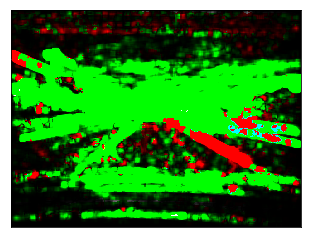

In [18]:
#test optical flow image

# ind1 = random.randint(0,len(data_df)-2)
# ind2 = ind1 +1

ind1 = 74
ind2 = ind1+1


img1 = mpimg.imread(data_df.iloc[ind1]['image_path'])
img2 = mpimg.imread(data_df.iloc[ind2]['image_path'])

rgb_diff = opticalFlowDense(img1,img2)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)

### Cropping

In [9]:
# First, use online tool to determine rough coordinates for cropping (https://www.image-map.net/)


def crop_image(image):
    
    dimensions = image.shape
    height = dimensions[0]
    width = dimensions[1]
    channels = dimensions[2]
    
    
    # Crop out hood of car + top black line
    image_cropped = image[10:355, 0:width] 
    
#     height = int(240*scale)
#     width = int(640*scale)
#     image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image_cropped

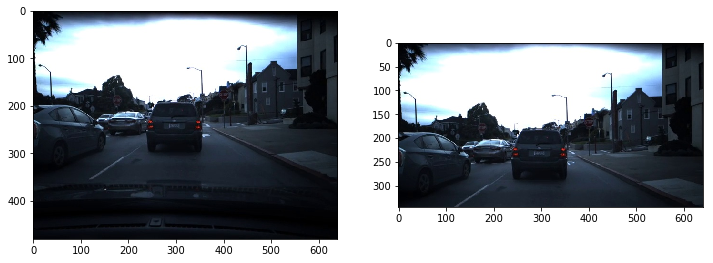

In [20]:
#check

ind1 = 20390
ind2 = ind1+1

img1 = mpimg.imread(data_df.iloc[ind1]['image_path'])
img2 = mpimg.imread(data_df.iloc[ind2]['image_path'])

new_img = crop_image(img1)

fig = plt.figure(figsize = (12,12))
fig.add_subplot(1,2, 1)
plt.imshow(img1)
fig.add_subplot(1,2, 2)
plt.imshow(new_img)
plt.show(block=True)

In [10]:
#for validation data

def preprocess_image_valid_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image(img)
    return img

In [11]:
#for training data

def preprocess_image_from_path(image_path, bright_factor):
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor) #only change brightness for training
    img = crop_image(img)
    return img

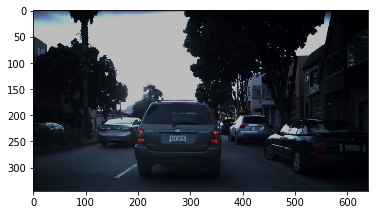

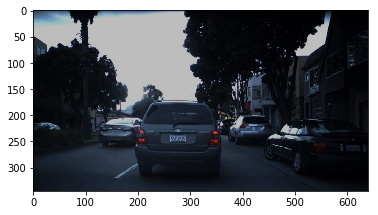

In [12]:
ind1 = 20390
ind2 = ind1+1

bright_factor = np.random.uniform()
img = preprocess_image_from_path(train_data.iloc[ind1]['image_path'], bright_factor)
img_next = preprocess_image_from_path(train_data.iloc[ind2]['image_path'], bright_factor)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(img_next)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


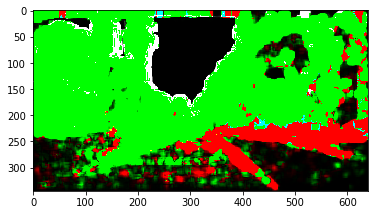

In [24]:
rgb_flow = opticalFlowDense(img,img_next)
plt.figure()
plt.imshow(rgb_flow)

## Generator functions

In [37]:
#data param should be train_data df
def generate_training_data(data, batch_size = 1024):
    # sample an image from the data to compute image size
    bright_factor = 0.5 + np.random.uniform()
    img = preprocess_image_from_path(data.iloc[1]['image_path'], bright_factor)

    # create empty batches
    image_batch = np.zeros((batch_size, img.shape[0], img.shape[1], img.shape[2]))
    label_batch = np.zeros(batch_size)
    i=0
    
    while i < len(data): #right?
        speed1 = data.iloc[i]['speed']
        speed2 = data.iloc[i+1]['speed']
        
        bright_factor = 0.5 + np.random.uniform()
        img1 = preprocess_image_from_path(data.iloc[i]['image_path'],bright_factor)
        img2 = preprocess_image_from_path(data.iloc[i+1]['image_path'],bright_factor)
        
        rgb_flow_diff = opticalFlowDense(img1, img2)
        avg_speed = np.mean([speed1,speed2])
        
        #for every 2 records, i create 1 entry
        image_batch[int((i/2)%batch_size)] = rgb_flow_diff
        label_batch[int((i/2)%batch_size)] = avg_speed
        
        #if (i/2)+1 a multiple of 16 aka produces a value of 0 when % 16, i return an image batch and label batch
        if not(((i/2)+1)%batch_size):
            yield image_batch, label_batch
        i+=2
#         i=i%data.shape[0]

In [38]:
def generate_validation_data(data, batch_size = 1024):
    i=0
    while i < len(data):
        speed1 = data.iloc[i]['speed']
        speed2 = data.iloc[i+1]['speed']
    
        img1 = preprocess_image_from_valid_path(data.iloc[i]['image_path'])
        img2 = preprocess_image_from_valid_path(data.iloc[i+1]['image_path'])
        
        rgb_diff = opticalFlowDense(img1, img2)
        rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
        avg_speed = np.array([[np.mean([speed1,speed2])]])
        
        yield rgb_diff, avg_speed

# Model

In [15]:
dir_name = "C:\\Users\\limxu\\Documents\\Intern\\data\\ori_images\\" #directory of all original frame images
test_img_path = random.choice(os.listdir(dir_name))
test_img_path = dir_name + test_img_path

bright_factor = 0.5 + np.random.uniform()

sample_image= preprocess_image_from_path(test_img_path, bright_factor)
dimensions = sample_image.shape
height = dimensions[0]
width = dimensions[1]
channels = dimensions[2]

print("height = " + str(height))
print("width = " + str(width))
print("channels = " + str(channels))

height = 345
width = 640
channels = 3


In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF


N_img_height = 345
N_img_width = 640
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


## Train

In [17]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'weights_best.h5'

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint, earlyStopping]

In [39]:
#setting params for fit generator

BATCH = 1024
steps_per_epoch = math.ceil(len(train_data)/BATCH)
validation_steps = math.ceil(len(valid_data)/BATCH)
print(math.ceil(steps_per_epoch))

29


In [ ]:
model = nvidia_model()
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, BATCH)



history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = 1,
    callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = validation_steps)

print(history)

Epoch 1/1


In [79]:
#test
def f1(t=0):
    print(t)
    
f1(t=4)

4
